<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_(_)_SentimentAnalysisLSTM_ipynb%22_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Домашнее задание со звездочкой

Попробуйте улучшить качество работы модели классификации отзывов, которую мы разобрали на вебинаре.

0. Разберите код с практики.

1.   Посмотрите на имплементацию [LSTM в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). Поиграйтесь с параметрами num_layers, hidden_size и embedding_dim: попробуйте увеличить одновременно все 3 параметра и  проверьте как их изменение повлияет на обучение.

2. При работе с нейросетями часто можно столкнуться с переобучением - модель "запоминает" обучающий датасет, но не учит общие закономерности. Прочитайте про методы борьбы с переобучением: [DropOut](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), [регуляризацию весов (weight decay)](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9), [Early Stopping](https://en.wikipedia.org/wiki/Early_stopping), [Gradient clipping](https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch). Примените любые 2 метода, посмотрите как изменится процесс обучения.

3. Если вышеперечисленные методы вам не помогают улучшить качество предсказаний, попробуйте пофильтровать данные. Например на вход модели мы можем подавать только часто-встречающиеся слова и игнорировать те, которые редко встречаются в датасете.

Например, измените строчку

```
corpus_ = sorted(corpus,key=corpus.get,reverse=True)
```

на

```
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
```
чтобы подавать на вход модели только топ-1000 часто-встречающихся слов.



# Классификация отзывов на фильмы с помощью LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



1.   Для начала тексты нужно токенизировать - разбить на слова и присвоить каждому слову id
2.   Затем каждое слово (токен) нужно передать в эмбеддинговый слой, чтобы получить компактный вектор
3.   Эмбеддинги передаем на вход в рекуррентную сеть (LSTM)
4.   После обработки последнего слова отзыва делаем предсказание.

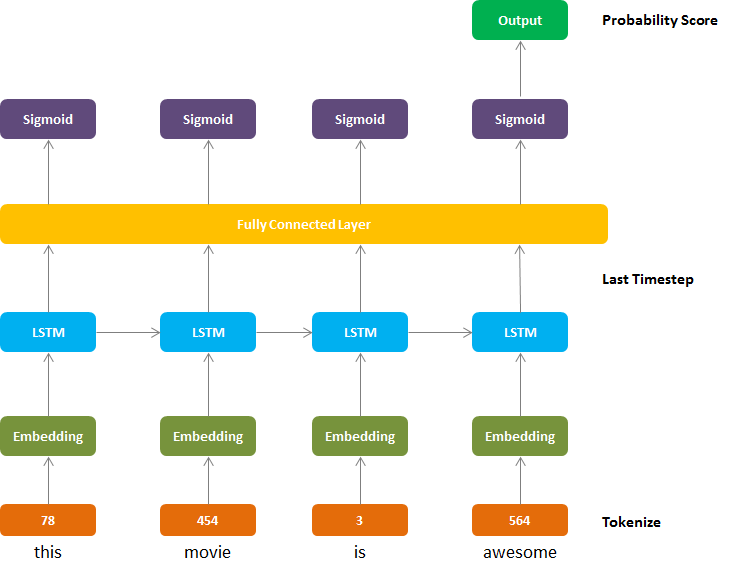

# Готовим данные

In [ ]:
import numpy as np
from string import punctuation
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm

import random
random.seed(33)
torch.manual_seed(0)

In [ ]:
# Считываем данные из файлов
with open('/content/drive/MyDrive/reviews.txt', 'r') as f:
    reviews = f.read()
with open('/content/drive/MyDrive/labels.txt', 'r') as f:
    labels = f.read()

In [ ]:
# Напечатаем первые 140 символов из файла с отзывами и 9 символов из файла с лейблами
print(reviews[:100])
print(labels[:9])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life
positive



In [ ]:
def preprocess(text):
    """"
    Функция чтобы разбить сплошной текст на отдельные отзывы, убрать пунктуацию
    и выделить все слова
    """
    text = "".join([s for s in text if s not in punctuation]) # убираем пунктуацию
    all_reviews = text.split("\n") # разделяем текст на ревью
    text = " ".join(all_reviews)
    all_words = text.split() # получаем массив слов

    return all_reviews, all_words


all_reviews, all_words = preprocess(reviews)
print('Общее число отзывов: ', len(all_reviews))

Общее число отзывов:  25001


In [ ]:
print('Первые 2 отзыва: ', all_reviews[:2])
print('Первые 5 слов: ', all_words[:5])

Первые 2 отзыва:  ['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned int

In [ ]:
corpus = Counter(all_words)
# Отсортируем слова по встречаемости
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[30:1000]
print('Самые частые слова: ', corpus_[:30])
# кодируем каждое слово - присваиваем ему порядковый номер
vocab_to_int = {w:i+1 for i,w in enumerate(corpus_)}
print('Уникальных слов: ', len(vocab_to_int))

# Кодируем все отзывы: последовательность слов --> последовательность чисел
encoded_reviews = []
for sent in all_reviews:
  encoded_reviews.append([vocab_to_int[word] for word in sent.lower().split()
                                  if word in vocab_to_int.keys()])
print('Пример закодированного ревью: ', encoded_reviews[0])

Самые частые слова:  ['all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she', 'when', 'very', 'up', 'time', 'no', 'even', 'my']
Уникальных слов:  970
Пример закодированного ревью:  [278, 177, 2, 141, 27, 19, 51, 14, 352, 80, 110, 30, 124, 445, 41, 230, 278, 44, 583, 43, 6, 21, 36, 174, 115, 37, 191, 853, 1, 41, 656, 37, 24, 186, 353, 32, 753, 150, 352, 2, 278, 319, 311, 113, 97, 99, 278, 498, 79, 30, 513, 72, 278, 197, 18, 185]


In [ ]:
all_labels = labels.split("\n")
encoded_labels = [1 if label == "positive" else 0 for label in all_labels]

print('Число отзывов и число лейблов: ', len(all_reviews), len(all_labels))

Число отзывов и число лейблов:  25001 25001


In [ ]:
encoded_labels = np.array( [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx]) > 0] )
encoded_reviews = [review for review in encoded_reviews if len(review) > 0]

print(len(encoded_labels), len(encoded_reviews))

25000 25000


Упакуем все последовательности, чтобы они имели одинаковую длину seq_len и могли быть организованы в тензоры по батчам

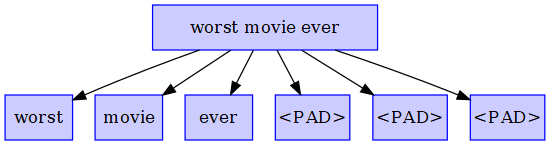

In [ ]:
def pad_text(encoded_reviews, seq_length):
    reviews = []
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)

    return np.array(reviews)


padded_reviews = pad_text(encoded_reviews, seq_length = 200)

In [ ]:
# dataset = TensorDataset(torch.from_numpy(padded_reviews), torch.from_numpy(encoded_labels))

train_set = TensorDataset(torch.from_numpy(padded_reviews[:20000]), torch.from_numpy(encoded_labels[:20000]))
val_set = TensorDataset(torch.from_numpy(padded_reviews[20000:]), torch.from_numpy(encoded_labels[20000:]))

In [ ]:
batch_size = 256

# train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-5000, 5000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  20000 5000


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Задаем модель

In [ ]:
class SentimentRNN(nn.Module):
    """
    Соберем модель для классификации текстов
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        """
        Инициализируем модель, обозначая слои и гиперпараметры
        """
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = num_layers)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()
        self.dropout=nn.Dropout(p=0.2)

    def forward(self, x, h):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, h)
        # print(lstm_out.shape)
        lstm_out = lstm_out[:, -1, :] # getting the last time step output


        out = self.dropout(lstm_out)
        # fully-connected layer
        out = self.fc(out)
        # sigmoid function
        out = self.sig(out)
        # return last sigmoid output
        return out

In [ ]:
vocab_size = len(vocab_to_int)+1
embedding_dim = 100
hidden_dim = 128
num_layers = 2
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
model.to(device)

#optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #Another optimizer - weight decay
lr = 0.001 # learning rate

Делаем EarlyStopper


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Обучаем

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

In [ ]:
def accuracy(outputs, labels):
    preds = torch.round(outputs.squeeze())
    # print(preds, labels)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def trainval(model, loaders, optimizer, epochs=5):
  """
  model: модель, которую собираемся обучать
  loaders: dict с dataloader'ами для обучения и валидации
  optimizer: оптимизатор
  epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
  """
  loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
  accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

  loss_track = {'training': [], 'validation': []}
  accuracy_track = {'training': [], 'validation': []}
  early_stopper = EarlyStopper(patience=3, min_delta=10)

  for epoch in range(epochs): # итерации по эпохам

      for mode in ['training', 'validation']: # обучение - валидация
          # считаем градиаент только при обучении:
          with torch.set_grad_enabled(mode == 'training'):


              # в зависимоти от фазы переводим модель в нужный ружим:
              model.train() if mode == 'training' else model.eval()


              for texts, labels in tqdm(loaders[mode]):
                  texts = texts.to(device) # отправляем тензор на GPU
                  labels = labels.to(device)
                  bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                  zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
                  h = tuple([zero_init, zero_init]) # задаем изначальный hidden state модели

                  preds = model(texts, h) # forward pass - прогоняем тензор с картинками через модель
                  loss = nn.BCELoss()(preds.squeeze(), labels.float())
                  loss_f=loss.item()
                  loss_meter[mode].add(loss_f, bs)


                  #print(loss.item())
                  # если мы в фазе обучения

                  if mode == 'training':
                      optimizer.zero_grad() # обнуляем прошлый градиент
                      loss.backward() # делаем backward pass (считаем градиент)
                      optimizer.step() # обновляем веса

                  #if mode == 'training':
                  #    train_loss=loss_meter[mode][:-1]
                  if mode == 'validation':
                      validation_loss=loss_f
                  acc = accuracy(preds, labels) # считаем метрику
                  # храним loss и accuracy для батча
                  accuracy_meter[mode].add(acc, bs)


          # в конце фазы выводим значения loss и accuracy
          log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

          # сохраняем результаты по всем эпохам
          loss_track[mode].append(loss_meter[mode].value())
          accuracy_track[mode].append(accuracy_meter[mode].value())

      if early_stopper.early_stop(validation_loss):
        print("early_stop")
        break
  return loss_track, accuracy_track

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=30)

100%|██████████| 79/79 [00:03<00:00, 21.07it/s]


[training] Epoch: 0.00. Loss: 0.60. Accuracy: 66.74% 


100%|██████████| 20/20 [00:00<00:00, 36.84it/s]


[validation] Epoch: 0.00. Loss: 0.48. Accuracy: 77.56% 


100%|██████████| 79/79 [00:03<00:00, 23.01it/s]


[training] Epoch: 1.00. Loss: 0.53. Accuracy: 73.10% 


100%|██████████| 20/20 [00:00<00:00, 40.67it/s]


[validation] Epoch: 1.00. Loss: 0.46. Accuracy: 79.35% 


100%|██████████| 79/79 [00:03<00:00, 22.93it/s]


[training] Epoch: 2.00. Loss: 0.49. Accuracy: 76.24% 


100%|██████████| 20/20 [00:00<00:00, 41.10it/s]


[validation] Epoch: 2.00. Loss: 0.44. Accuracy: 80.53% 


100%|██████████| 79/79 [00:03<00:00, 21.87it/s]


[training] Epoch: 3.00. Loss: 0.45. Accuracy: 78.42% 


100%|██████████| 20/20 [00:00<00:00, 32.29it/s]


[validation] Epoch: 3.00. Loss: 0.42. Accuracy: 81.43% 


100%|██████████| 79/79 [00:03<00:00, 21.53it/s]


[training] Epoch: 4.00. Loss: 0.43. Accuracy: 79.88% 


100%|██████████| 20/20 [00:00<00:00, 30.72it/s]


[validation] Epoch: 4.00. Loss: 0.41. Accuracy: 81.95% 


100%|██████████| 79/79 [00:03<00:00, 21.67it/s]


[training] Epoch: 5.00. Loss: 0.41. Accuracy: 81.03% 


100%|██████████| 20/20 [00:00<00:00, 40.26it/s]


[validation] Epoch: 5.00. Loss: 0.40. Accuracy: 82.38% 


100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


[training] Epoch: 6.00. Loss: 0.40. Accuracy: 81.97% 


100%|██████████| 20/20 [00:00<00:00, 31.34it/s]


[validation] Epoch: 6.00. Loss: 0.40. Accuracy: 82.63% 


100%|██████████| 79/79 [00:03<00:00, 21.92it/s]


[training] Epoch: 7.00. Loss: 0.38. Accuracy: 82.76% 


100%|██████████| 20/20 [00:00<00:00, 42.15it/s]


[validation] Epoch: 7.00. Loss: 0.39. Accuracy: 82.86% 


100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


[training] Epoch: 8.00. Loss: 0.37. Accuracy: 83.44% 


100%|██████████| 20/20 [00:00<00:00, 41.23it/s]


[validation] Epoch: 8.00. Loss: 0.40. Accuracy: 82.63% 


100%|██████████| 79/79 [00:03<00:00, 23.49it/s]


[training] Epoch: 9.00. Loss: 0.36. Accuracy: 84.04% 


100%|██████████| 20/20 [00:00<00:00, 41.38it/s]


[validation] Epoch: 9.00. Loss: 0.40. Accuracy: 82.85% 


100%|██████████| 79/79 [00:03<00:00, 21.65it/s]


[training] Epoch: 10.00. Loss: 0.35. Accuracy: 84.64% 


100%|██████████| 20/20 [00:00<00:00, 35.63it/s]


[validation] Epoch: 10.00. Loss: 0.39. Accuracy: 82.97% 


100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


[training] Epoch: 11.00. Loss: 0.34. Accuracy: 85.24% 


100%|██████████| 20/20 [00:00<00:00, 40.98it/s]


[validation] Epoch: 11.00. Loss: 0.40. Accuracy: 82.97% 


100%|██████████| 79/79 [00:03<00:00, 23.48it/s]


[training] Epoch: 12.00. Loss: 0.33. Accuracy: 85.71% 


100%|██████████| 20/20 [00:00<00:00, 40.83it/s]


[validation] Epoch: 12.00. Loss: 0.40. Accuracy: 83.09% 


100%|██████████| 79/79 [00:03<00:00, 22.58it/s]


[training] Epoch: 13.00. Loss: 0.32. Accuracy: 86.17% 


100%|██████████| 20/20 [00:00<00:00, 32.45it/s]


[validation] Epoch: 13.00. Loss: 0.41. Accuracy: 83.18% 


100%|██████████| 79/79 [00:03<00:00, 22.35it/s]


[training] Epoch: 14.00. Loss: 0.31. Accuracy: 86.60% 


100%|██████████| 20/20 [00:00<00:00, 41.38it/s]


[validation] Epoch: 14.00. Loss: 0.41. Accuracy: 83.24% 


100%|██████████| 79/79 [00:03<00:00, 23.40it/s]


[training] Epoch: 15.00. Loss: 0.30. Accuracy: 87.07% 


100%|██████████| 20/20 [00:00<00:00, 41.51it/s]


[validation] Epoch: 15.00. Loss: 0.41. Accuracy: 83.20% 


100%|██████████| 79/79 [00:03<00:00, 23.39it/s]


[training] Epoch: 16.00. Loss: 0.29. Accuracy: 87.35% 


100%|██████████| 20/20 [00:00<00:00, 35.77it/s]


[validation] Epoch: 16.00. Loss: 0.42. Accuracy: 83.23% 


100%|██████████| 79/79 [00:03<00:00, 21.47it/s]


[training] Epoch: 17.00. Loss: 0.28. Accuracy: 87.75% 


100%|██████████| 20/20 [00:00<00:00, 40.94it/s]


[validation] Epoch: 17.00. Loss: 0.42. Accuracy: 83.29% 


100%|██████████| 79/79 [00:03<00:00, 23.04it/s]


[training] Epoch: 18.00. Loss: 0.28. Accuracy: 88.19% 


100%|██████████| 20/20 [00:00<00:00, 40.75it/s]


[validation] Epoch: 18.00. Loss: 0.43. Accuracy: 83.32% 


100%|██████████| 79/79 [00:03<00:00, 23.02it/s]


[training] Epoch: 19.00. Loss: 0.27. Accuracy: 88.61% 


100%|██████████| 20/20 [00:00<00:00, 40.01it/s]


[validation] Epoch: 19.00. Loss: 0.44. Accuracy: 83.31% 


100%|██████████| 79/79 [00:03<00:00, 21.59it/s]


[training] Epoch: 20.00. Loss: 0.26. Accuracy: 88.97% 


100%|██████████| 20/20 [00:00<00:00, 31.69it/s]


[validation] Epoch: 20.00. Loss: 0.44. Accuracy: 83.33% 


100%|██████████| 79/79 [00:03<00:00, 22.29it/s]


[training] Epoch: 21.00. Loss: 0.25. Accuracy: 89.34% 


100%|██████████| 20/20 [00:00<00:00, 38.13it/s]


[validation] Epoch: 21.00. Loss: 0.45. Accuracy: 83.31% 


100%|██████████| 79/79 [00:03<00:00, 22.84it/s]


[training] Epoch: 22.00. Loss: 0.24. Accuracy: 89.71% 


100%|██████████| 20/20 [00:00<00:00, 40.29it/s]


[validation] Epoch: 22.00. Loss: 0.46. Accuracy: 83.30% 


100%|██████████| 79/79 [00:03<00:00, 21.99it/s]


[training] Epoch: 23.00. Loss: 0.23. Accuracy: 90.06% 


100%|██████████| 20/20 [00:00<00:00, 30.53it/s]


[validation] Epoch: 23.00. Loss: 0.48. Accuracy: 83.28% 


100%|██████████| 79/79 [00:03<00:00, 21.87it/s]


[training] Epoch: 24.00. Loss: 0.23. Accuracy: 90.38% 


100%|██████████| 20/20 [00:00<00:00, 39.85it/s]


[validation] Epoch: 24.00. Loss: 0.49. Accuracy: 83.24% 


100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


[training] Epoch: 25.00. Loss: 0.22. Accuracy: 90.68% 


100%|██████████| 20/20 [00:00<00:00, 40.74it/s]


[validation] Epoch: 25.00. Loss: 0.50. Accuracy: 83.24% 


100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


[training] Epoch: 26.00. Loss: 0.21. Accuracy: 90.97% 


100%|██████████| 20/20 [00:00<00:00, 35.22it/s]


[validation] Epoch: 26.00. Loss: 0.52. Accuracy: 83.12% 


100%|██████████| 79/79 [00:03<00:00, 20.89it/s]


[training] Epoch: 27.00. Loss: 0.21. Accuracy: 91.21% 


100%|██████████| 20/20 [00:00<00:00, 30.36it/s]


[validation] Epoch: 27.00. Loss: 0.53. Accuracy: 83.12% 


100%|██████████| 79/79 [00:03<00:00, 21.80it/s]


[training] Epoch: 28.00. Loss: 0.20. Accuracy: 91.49% 


100%|██████████| 20/20 [00:00<00:00, 41.13it/s]


[validation] Epoch: 28.00. Loss: 0.54. Accuracy: 83.09% 


100%|██████████| 79/79 [00:03<00:00, 21.30it/s]


[training] Epoch: 29.00. Loss: 0.20. Accuracy: 91.74% 


100%|██████████| 20/20 [00:00<00:00, 24.73it/s]

[validation] Epoch: 29.00. Loss: 0.55. Accuracy: 83.02% 


# Смотрим результаты

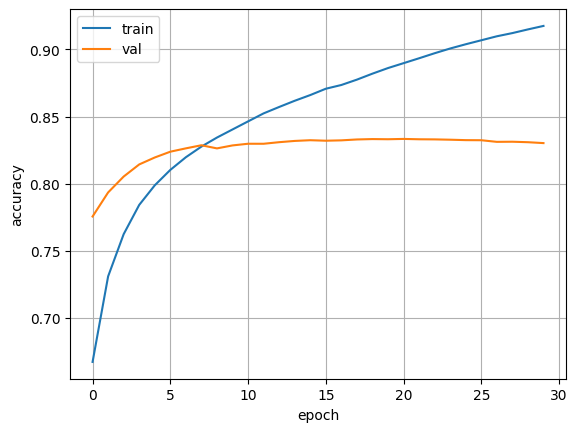

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='train')
plt.plot(accuracy_track['validation'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

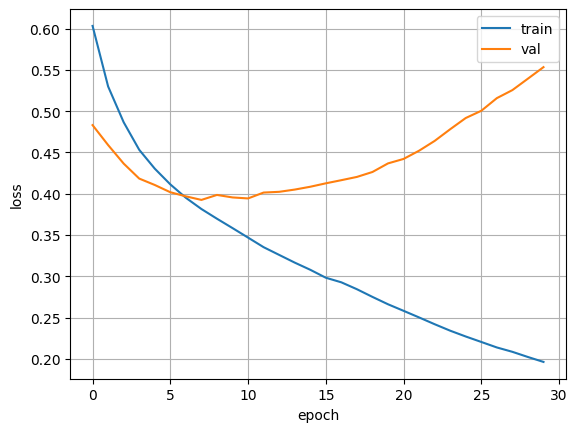

In [ ]:
plt.plot(loss_track['training'], label='train')
plt.plot(loss_track['validation'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [ ]:
def predict(model, review, seq_length = 200):
    print(review)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    _, words = preprocess(review.lower())
    encoded_words = [vocab_to_int[word] for word in words if word in vocab_to_int.keys()]
    padded_words = pad_text([encoded_words], seq_length)
    padded_words = torch.from_numpy(padded_words).to(device)
    bs=1
    model.eval()
    zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
    h = tuple([zero_init, zero_init])
    output = model(padded_words, h)
    pred = torch.round(output.squeeze())
    out = "This is a positive review." if pred == 1 else "This is a negative review."
    print(out, '\n')


review1 = "Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece"
review2 = "It made me cry"
review3 = "It made me cry - I never seen such an awful acting before"
review4 = "Vulgarity. Ringing vulgarity"
review5 = "Awful"

predict(model, review1)
predict(model, review2)
predict(model, review3)
predict(model, review4)
predict(model, review5)

Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece
This is a positive review. 

It made me cry
This is a negative review. 

It made me cry - I never seen such an awful acting before
This is a negative review. 

Vulgarity. Ringing vulgarity
This is a negative review. 

Awful
This is a negative review. 

